# Setting up our Notebook

In [1]:
# Things to import

# Standard data, plotting, and mathematical tools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import seaborn as sns

# PCA
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# CNN
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from tensorflow import keras
from sklearn.model_selection import GridSearchCV
from scikeras.wrappers import KerasClassifier

# Importing the data

In [5]:
# Importing the data

dfs=['Non-Scaled TA Features 1H for BTC.csv']

# Convolutional Neural Network

## Description

### Convolution

A convolution is an operation which passes filters over the image and transforms it into a Feature Map. They can be thout of as detecting increasingly complex patterns in the pixel data.

Graphically, this can be represented as:

<img src="Graphics/Convolution.png" width="600" height="600" />

### Convolution, Pooling, and Fully-Connected Layers

After a round of convolutions, given that one might have many filters, the feature map will be quite large. A Pooling Layer follows which takes sections of the feature map and finds either the Average or the Max among the values and creates a second, pooled feature map. After several iterations of this, the final feature map is flattened and fed to a fully-connected layer, or just a regular DNN/MLP.

Graphically, this can be represented as:

<img src="Graphics/CNN.png" width="600" height="600" />

## Training

### Getting the train/test data

In [6]:
# Defining a function to create two PCA matrices

def PCA_creation_train_test(no_components, X_train, X_test):
    
    # Scaling the data with our X_train matrix
    scaler=StandardScaler()
    X_train=scaler.fit_transform(X_train)
    
    # Fitting the PCA to our X_train matrix
    pca=PCA(n_components=no_components)
    X_train=pca.fit_transform(X_train)

    # Scaling X_test 
    X_test=scaler.transform(X_test)

    # Transforming X_test
    X_test=pca.transform(X_test)
    
    return X_train, X_test

In [7]:
# Train and test splitting and scaling
X=pd.read_csv(dfs[0])

X['Date']=pd.to_datetime(X['Date']) # Setting the index as the Date
X=X.set_index('Date').asfreq('H')

X=X.dropna()
y=X['Label']
X=X.drop('Label', axis=1)
X=X.drop('Percent Change', axis=1)


# Removing the testing data
X_test=X[-4380:] # Getting the last 6 months as the testing data
print('Confirming we have all the columns we want:','\n', X_test.columns)
y_test=y[-4380:].values

X=X[:-4380] # Getting everything but the first 6 months as the training data
y=y[:-4380]

Confirming we have all the columns we want: 
 Index(['BB_upper 10', 'BB_middle 10', 'BB_lower 10', 'Aroon_down 10',
       'Aroon_up 10', 'Aroonosc 10', 'RSI 10', 'NATR 10', 'BB_upper 12',
       'BB_middle 12',
       ...
       'MACD Signal 18', 'MACD Hist18', 'Med Price', 'Chaikin A/D Line',
       'HT Dom Phase', 'HT Dom Period', 'High', 'Low', 'Close', 'Volume'],
      dtype='object', length=101)


### Creating "images" of our sets

In [8]:
# Image creation function

def image_creation(n_steps, X, y):
    X_images=[]
    y_values=[]
    
    for i in range(n_steps, len(X)):
        img=X[i-n_steps,:]
        img=np.vstack((img, X[i-n_steps+1,:]))
        img=np.vstack((img, X[i-n_steps+2,:]))
        img=np.vstack((img, X[i-n_steps+3,:]))
        img=np.vstack((img, X[i-n_steps+4,:]))
        img=np.vstack((img, X[i-n_steps+5,:]))
        img=np.vstack((img, X[i-n_steps+6,:]))
        img=np.vstack((img, X[i-n_steps+7,:]))
        img=np.vstack((img, X[i-n_steps+8,:]))
        img=np.vstack((img, X[i-n_steps+9,:]))
        img=np.vstack((img, X[i-n_steps+10,:]))
        img=np.vstack((img, X[i-n_steps+11,:]))
        X_images.append(img)
        y_values.append(int(y[i-n_steps+11]))
        
    return X_images, np.array(y_values) # Note, this will not include the very last one.

In [9]:
n_steps=12

# First, we create our PCA matrices from the X and X_test
X, X_test=PCA_creation_train_test(20, X, X_test)
print('Second to last X and y test after PCA:', '\n',X_test[-2], y_test[-2])
print('Final X and y test after PCA:', '\n',X_test[-1], y_test[-1])
    
# Getting the X and X_test matrices' images
X_set, y_set=image_creation(n_steps, X ,y)
X_test, y_test=image_creation(n_steps, X_test, y_test)


# Split X into training and validation for our neural net
X_train, X_val, y_train, y_val=train_test_split(X_set, y_set, test_size=0.2, random_state=100, shuffle=True)
# Note, we have already made our images from sequential time slices, so we can shuffle our sets of images

y_train=np.array(y_train)
y_val=np.array(y_val)
y_test=np.array(y_test)

# Finalizing the shapes
num_classes = 2
input_shape = (n_steps, len(X[0]), 1)

# Add a dimension at the end to make sure images have shape (n_steps, n_features, 1)
X_train = np.expand_dims(X_train, -1)
X_val = np.expand_dims(X_val, -1)
X_test = np.expand_dims(X_test, -1)

print("X_train shape:", X_train.shape)
print(X_train.shape[0], "train samples")
print(X_val.shape[0], "val samples")
print(X_test.shape[0], "test samples")

print('Final X and y test after PCA:', '\n',X_test[-1][-1], y_test[-1])

Second to last X and y test after PCA: 
 [12.00381295 10.53103332 -1.88724162 -1.1895646  -2.92464478  3.88806865
 -0.08486031 -1.60395372 -2.61335648 -0.14934652 -0.73597246  1.54475008
  2.1361784  -1.16336855 -0.96483312 -0.52009332 -0.53966392  0.15052979
 -0.07019397  0.08884808] 0.0
Final X and y test after PCA: 
 [ 1.19564840e+01  1.00366560e+01 -6.45265865e-01 -1.32061430e+00
 -3.30942941e+00  3.79137389e+00  4.11759151e-01 -7.04865916e-01
 -1.77866589e+00 -4.68654783e-01 -8.73414523e-01  1.15515299e+00
  1.72232772e+00 -9.64270883e-01 -1.74905022e+00 -3.91583857e-01
 -4.62367228e-01 -5.02975770e-03 -4.92897987e-02 -2.06024229e-01] 0.0
X_train shape: (21011, 12, 20, 1)
21011 train samples
5253 val samples
4368 test samples
Final X and y test after PCA: 
 [[12.00381295]
 [10.53103332]
 [-1.88724162]
 [-1.1895646 ]
 [-2.92464478]
 [ 3.88806865]
 [-0.08486031]
 [-1.60395372]
 [-2.61335648]
 [-0.14934652]
 [-0.73597246]
 [ 1.54475008]
 [ 2.1361784 ]
 [-1.16336855]
 [-0.96483312]
 [

This confirms that our "image" creation function does not include the final datum.

### Grid Search

In [10]:
# Function to create the model for Keras wrapper to scikit learn

# Now, we will run grid search on the optimizer.

def create_cnn_model(pool_type='max', conv_activation='sigmoid', activ_function='relu',
                     dropout_rate=0.1, filters=16, kern_size=2, neurons=256,
                     mid_layers=1, optimizer='adam', learning_rate=1e-3):
    # Create model
    model = keras.Sequential()
    
    # First layer: convolution
    model.add(keras.layers.Conv2D(filters, kernel_size=(kern_size, kern_size), activation=conv_activation,
                                  input_shape=(n_steps,20,1))) 
        
    # First layer
    if mid_layers==1:
        if pool_type == 'max':
            model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
        if pool_type == 'average':
            model.add(keras.layers.AveragePooling2D(pool_size=(2, 2)))
    
    # Second layer  
    if mid_layers==2:  
        if pool_type == 'max':
            model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
        if pool_type == 'average':
            model.add(keras.layers.AveragePooling2D(pool_size=(2, 2))) 
        model.add(keras.layers.Conv2D(2*filters, kernel_size=(kern_size, kern_size), activation=conv_activation, padding='same'))
        if pool_type == 'max':
            model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
        if pool_type == 'average':
            model.add(keras.layers.AveragePooling2D(pool_size=(2, 2))) 
        
    # Third layer
    if mid_layers==3:   
        if pool_type == 'max':
            model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
        if pool_type == 'average':
            model.add(keras.layers.AveragePooling2D(pool_size=(2, 2)))
        model.add(keras.layers.Conv2D(2*filters, kernel_size=(kern_size, kern_size), activation=conv_activation, padding='same'))
        if pool_type == 'max':
            model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
        if pool_type == 'average':
            model.add(keras.layers.AveragePooling2D(pool_size=(2, 2)))
        model.add(keras.layers.Conv2D(4*filters, kernel_size=(kern_size, kern_size), activation=conv_activation, padding='same'))
        if pool_type == 'max':
            model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
        if pool_type == 'average':
            model.add(keras.layers.AveragePooling2D(pool_size=(2, 2)))
        
    # Fourth layer   
    if mid_layers==4:   
        if pool_type == 'max':
            model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
        if pool_type == 'average':
            model.add(keras.layers.AveragePooling2D(pool_size=(2, 2)))
        model.add(keras.layers.Conv2D(2*filters, kernel_size=(kern_size, kern_size), activation=conv_activation, padding='same'))
        if pool_type == 'max':
            model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
        if pool_type == 'average':
            model.add(keras.layers.AveragePooling2D(pool_size=(2, 2)))
        model.add(keras.layers.Conv2D(4*filters, kernel_size=(kern_size, kern_size), activation=conv_activation, padding='same'))
        if pool_type == 'max':
            model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
        if pool_type == 'average':
            model.add(keras.layers.AveragePooling2D(pool_size=(2, 2)))
        model.add(keras.layers.Conv2D(2*filters, kernel_size=(kern_size, kern_size), activation=conv_activation, padding='same'))
        if pool_type == 'max':
            model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
        if pool_type == 'average':
            model.add(keras.layers.AveragePooling2D(pool_size=(2, 2)))
        
    # Penultimate layer with Flatten, Dense, and Dropout from the MLP grid search
    model.add(keras.layers.Flatten())         
    # First Fully Connected Layer
    model.add(keras.layers.Dense(neurons, activation=activ_function))
    model.add(keras.layers.Dropout(dropout_rate))
    # Second Fully Connected layer
    model.add(keras.layers.Dense(neurons, activation=activ_function))
    model.add(keras.layers.Dropout(dropout_rate))
    
    # Final layer with the sigmoid for classification
    model.add(keras.layers.Dense(1, activation='sigmoid'))
    
    # Running through the optimizers
    if optimizer=='adam':
        optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
        
    if optimizer=='RMSprop':
        optimizer = keras.optimizers.RMSProp(learning_rate=learning_rate)
        
    if optimizer=='SGD':
        optimizer = keras.optimizers.SGD(learning_rate=learning_rate)
        
    # Compile model
    model.compile( 
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=['accuracy'],
        )    
    return model

Note, the grid search section for this script, as well as the MLP and LSTM, take heavy influence from the following Kaggle notebook: MNIST: CNN, grid search, data augmentation

This can be found at:

https://www.kaggle.com/code/cedricb/mnist-cnn-grid-search-data-augmentation/notebook

In [11]:
# Creating and compiling the model with a summary

cnn = create_cnn_model()
cnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 11, 19, 16)        80        
                                                                 
 max_pooling2d (MaxPooling2D  (None, 5, 9, 16)         0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 720)               0         
                                                                 
 dense (Dense)               (None, 256)               184576    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                      

In [21]:
# Optimize the model with grid search


# Grid search parameters
n_epochs_cv = 30 # Number of epochs for our grid search
n_cv = 3 # Number of cross validations

# Create model to feed to our parameter grid search
model = KerasClassifier(model=create_cnn_model, verbose=1)

# Define parameters and values for grid search to check in our model
param_grid = {
    # The features to range over in our model
    'model__pool_type': ['max', 'average'],
    'model__conv_activation': ['relu', 'sigmoid', 'tanh'],
    'model__activ_function':['tanh'],
    'model__filters': [16, 32, 64, 128],
    'model__neurons':[512],
    'model__dropout_rate':[0.6],
    'model__optimizer':['adam'],
    'model__kern_size':[2, 3],
    'model__mid_layers':[1, 2],
     # The features to range over for our optimizer
    'model__learning_rate':[1e-5],
    # The number of epochs for each model
    'epochs': [n_epochs_cv],
}

# Creating the grid
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=1, cv=n_cv)

# Fitting the grid
grid_result = grid.fit(X_train, y_train)

In [16]:
print(grid_result.best_params_)

{'epochs': 1, 'model__activ_function': 'tanh', 'model__conv_activation': 'relu', 'model__dropout_rate': 0.6, 'model__filters': 128, 'model__kern_size': 3, 'model__learning_rate': 1e-05, 'model__mid_layers': 1, 'model__neurons': 512, 'model__optimizer': 'adam', 'model__pool_type': 'max'}


### CNN with Optimized Parameters

In [ ]:
# Creating and compiling a model with the best parameters from the grid search

cnn_model = create_cnn_model(pool_type = grid_result.best_params_['pool_type'],
                             conv_activation = grid_result.best_params_['conv_activation'],
                             activ_function=grid_result.best_params_['activ_function'],
                            neurons=grid_result.best_params_['neurons'],
                             filters=grid_result.best_params_['filters'],
                             mid_layers=grid_result.best_params_['mid_layers'],
                            dropout_rate=grid_result.best_params_['dropout_rate'],
                            optimizer=grid_result.best_params_['optimizer'],
                            kern_size=grid_result.best_params_['kern_size'],
                             learning_rate=grid_result.best_params_['learning_rate'])
# Fitting the model
history = cnn_model.fit(X_train, y_train, epochs=100, validation_data=(X_val,y_val), verbose=1)

In [65]:
# Creating and compiling a model with the best parameters from the cluster

cnn_model = create_cnn_model(pool_type = 'average', conv_activation = 'tanh', activ_function='tanh',
                            neurons=512, filters=64, mid_layers=1, dropout_rate=0.6, optimizer='adam',
                            kern_size=3, learning_rate=1e-5)
# Fitting the model
history = cnn_model.fit(X_train, y_train, epochs=35, validation_data=(X_val,y_val), verbose=1)

Epoch 1/35
657/657 [==============================] - 25s 37ms/step - loss: 0.7354 - accuracy: 0.5048 - val_loss: 0.6918 - val_accuracy: 0.5207
Epoch 2/35
657/657 [==============================] - 24s 36ms/step - loss: 0.7310 - accuracy: 0.5099 - val_loss: 0.6912 - val_accuracy: 0.5357
Epoch 3/35
657/657 [==============================] - 24s 36ms/step - loss: 0.7238 - accuracy: 0.5086 - val_loss: 0.6922 - val_accuracy: 0.5195
Epoch 4/35
657/657 [==============================] - 24s 37ms/step - loss: 0.7203 - accuracy: 0.5122 - val_loss: 0.6928 - val_accuracy: 0.5197
Epoch 5/35
657/657 [==============================] - 28s 42ms/step - loss: 0.7173 - accuracy: 0.5121 - val_loss: 0.6902 - val_accuracy: 0.5300
Epoch 6/35
657/657 [==============================] - 21s 32ms/step - loss: 0.7130 - accuracy: 0.5226 - val_loss: 0.6901 - val_accuracy: 0.5369
Epoch 7/35
657/657 [==============================] - 20s 30ms/step - loss: 0.7072 - accuracy: 0.5249 - val_loss: 0.6905 - val_accuracy:

### Performance

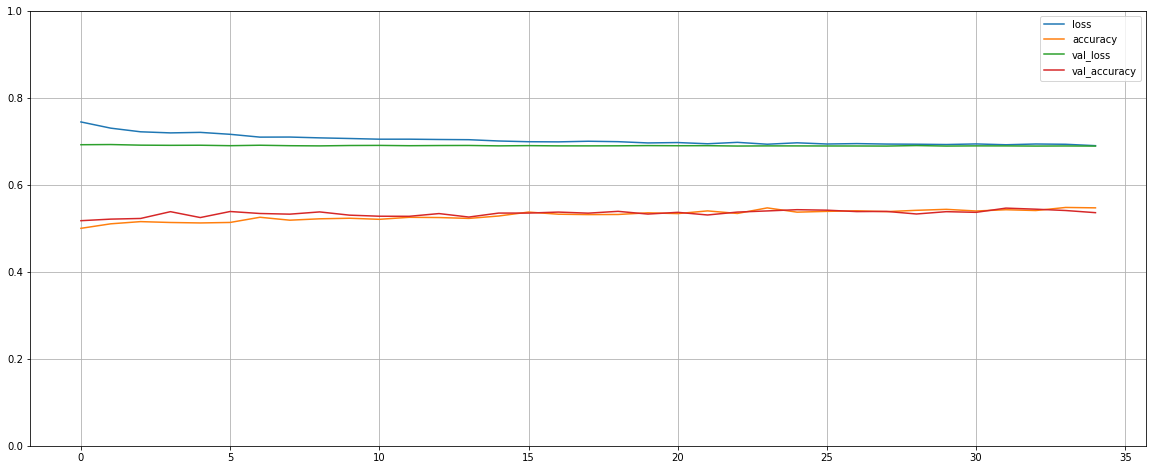

In [56]:
# Training Performance

history.history.keys()
pd.DataFrame(history.history).plot(figsize=(20, 8))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

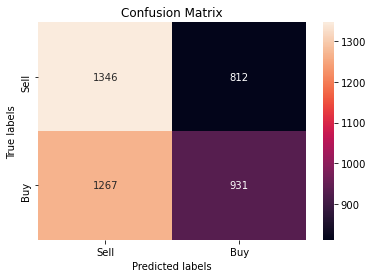

In [66]:
# Confusion Matrix

# # Performance
y_pred=cnn_model.predict(X_test) # Returns a list where every element is an array with the continuous
# value prediction
y_pred=[x[0] for x in y_pred] # Getting all the continuous value predictions from the arrays
for i in range(len(y_pred)): # Transforming the continuous value into binary labels
    if y_pred[i] <= 0.5:
        y_pred[i] = 0
    if y_pred[i] > 0.5:
        y_pred[i] = 1

# Plotting Confusion Matrix
cm=confusion_matrix(y_test, y_pred)
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Sell', 'Buy']); ax.yaxis.set_ticklabels(['Sell', 'Buy']);

### Saving and Reloading the Model

In [67]:
# Saving the model

cnn_model.save('Models/CNN 24_4 BTC.h5')

In [ ]:
# Reloading the model

cnn_model_BTC=model = keras.models.load_model('Models/CNN 1H BTC.h5')